In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')


Data fields
Input variables:

# bank client data:

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

# related with the last contact of the current campaign:

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.


# other attributes:

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')


# social and economic context attributes

16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)

17 - cons.price.idx: consumer price index - monthly indicator (numeric)

18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)

19 - euribor3m: euribor 3 month rate - daily indicator (numeric)

20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target): 
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

# Clean Train data

In [2]:
data= pd.read_csv('./datasets/train.csv',sep=";")
data.shape

(2999, 21)

In [3]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [4]:
data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

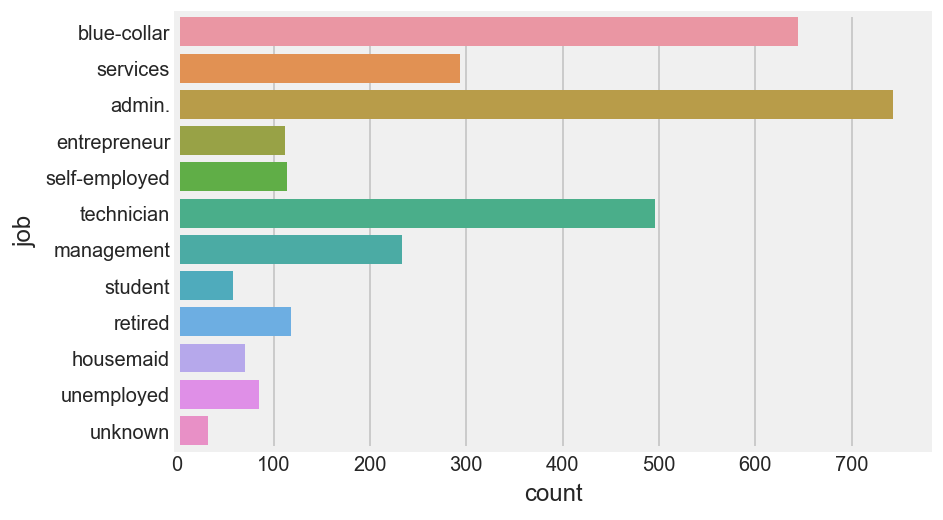

In [5]:
sns.countplot(y="job", data=data)
plt.show()

<function matplotlib.pyplot.show>

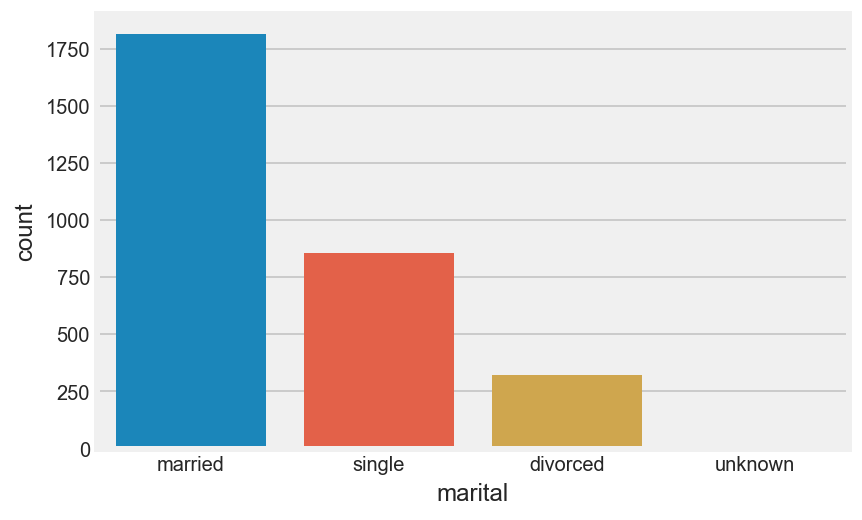

In [6]:
sns.countplot(x="marital",data=data)
plt.show

<function matplotlib.pyplot.show>

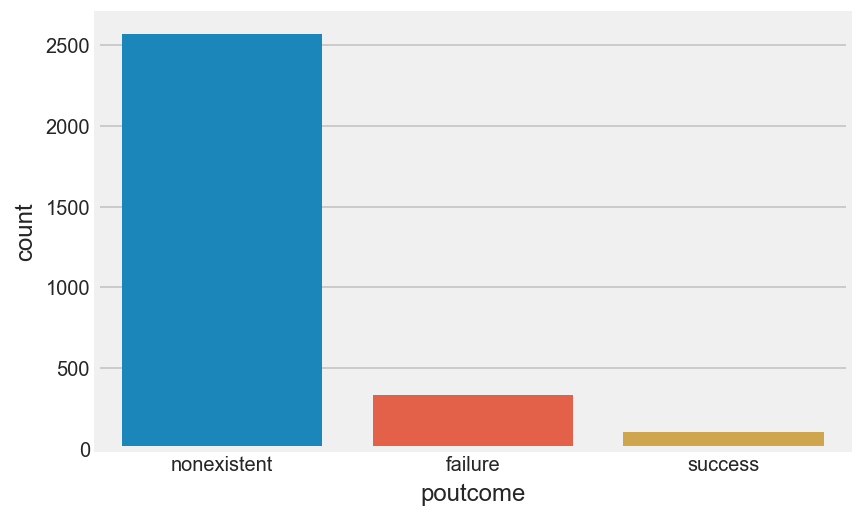

In [7]:
sns.countplot(x="poutcome",data=data)
plt.show

In [8]:
data.groupby('y').mean()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,,
no,39.673538,216.016867,2.602699,984.110195,0.141304,0.216154,93.596114,-40.654273,3.769919,5174.121852
yes,41.628399,569.990937,1.915408,785.845921,0.601208,-1.025680,93.491360,-39.965257,2.282650,5097.293656


In [9]:
data.marital.value_counts(normalize=True)

married     0.604201
single      0.285428
divorced    0.107369
unknown     0.003001
Name: marital, dtype: float64

### Convert categorical vaiables to numerical to check their multicullinearities

In [10]:
data.marital=data.marital.map(lambda x: 1 if x == 'married' else x)
data.marital=data.marital.map(lambda x: 2 if x == 'single' else x)
data.marital=data.marital.map(lambda x: 3 if x == 'divorced' else x)
data.marital=data.marital.map(lambda x: 3 if x == 'unknown' else x)

In [11]:
#Let us group “basic.4y”, “basic.9y” and “basic.6y” together and call them “basic”.

data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])

In [12]:
data.education.value_counts(normalize=True)

university.degree      0.305102
Basic                  0.295098
high.school            0.226742
professional.course    0.127042
unknown                0.046015
Name: education, dtype: float64

In [13]:
data.education=data.education.map(lambda x: 1 if x == 'university.degree' else x)
data.education=data.education.map(lambda x: 2 if x == 'high.school' else x)
data.education=data.education.map(lambda x: 3 if x == 'Basic' else x)
data.education=data.education.map(lambda x: 4 if x == 'professional.course' else x)
#data.education=data.education.map(lambda x: 5 if x == 'basic.4y' else x)
#data.education=data.education.map(lambda x: 6 if x == 'basic.6y' else x)
data.education=data.education.map(lambda x: 4 if x == 'unknown' else x)


In [14]:
data.default.value_counts(normalize=True)

no         0.801267
unknown    0.198733
Name: default, dtype: float64

In [15]:
data.default=data.default.map(lambda x: 1 if x == 'yes' else x)
data.default=data.default.map(lambda x: 2 if x == 'no' else x)
data.default=data.default.map(lambda x: 3 if x == 'unknown' else x)

In [16]:
data.housing.value_counts(normalize=True)

yes        0.529843
no         0.444481
unknown    0.025675
Name: housing, dtype: float64

In [17]:
data.housing=data.housing.map(lambda x: 1 if x == 'yes' else x)
data.housing=data.housing.map(lambda x: 2 if x == 'no' else x)
data.housing=data.housing.map(lambda x: 2 if x == 'unknown' else x)

In [18]:
data.loan.value_counts(normalize=True)

no         0.812604
yes        0.161721
unknown    0.025675
Name: loan, dtype: float64

In [19]:
data.loan=data.loan.map(lambda x: 1 if x == 'yes' else x)
data.loan=data.loan.map(lambda x: 2 if x == 'no' else x)
data.loan=data.loan.map(lambda x: 1 if x == 'unknown' else x)

In [20]:
data.contact=data.contact.map(lambda x: 1 if x == 'cellular' else x)
data.contact=data.contact.map(lambda x: 2 if x == 'telephone' else x)

In [21]:
data.month=data.month.map(lambda x: 1 if x == 'jan' else x)
data.month=data.month.map(lambda x: 2 if x == 'feb' else x)
data.month=data.month.map(lambda x: 3 if x == 'mar' else x)
data.month=data.month.map(lambda x: 4 if x == 'apr' else x)
data.month=data.month.map(lambda x: 5 if x == 'may' else x)
data.month=data.month.map(lambda x: 6 if x == 'jun' else x)
data.month=data.month.map(lambda x: 7 if x == 'jul' else x)
data.month=data.month.map(lambda x: 8 if x == 'aug' else x)
data.month=data.month.map(lambda x: 9 if x == 'sep' else x)
data.month=data.month.map(lambda x: 10 if x == 'oct' else x)
data.month=data.month.map(lambda x: 11 if x == 'nov' else x)
data.month=data.month.map(lambda x: 12 if x == 'dec' else x)



In [22]:
data.day_of_week=data.day_of_week.map(lambda x: 1 if x == 'mon' else x)
data.day_of_week=data.day_of_week.map(lambda x: 2 if x == 'tue' else x)
data.day_of_week=data.day_of_week.map(lambda x: 3 if x == 'wed' else x)
data.day_of_week=data.day_of_week.map(lambda x: 4 if x == 'thu' else x)
data.day_of_week=data.day_of_week.map(lambda x: 5 if x == 'fri' else x)
data.day_of_week=data.day_of_week.map(lambda x: 6 if x == 'sat' else x)
data.day_of_week=data.day_of_week.map(lambda x: 7 if x == 'sun' else x)



In [23]:
data.job.value_counts(normalize=True)

admin.           0.247749
blue-collar      0.214738
technician       0.165388
services         0.098033
management       0.077693
retired          0.039346
self-employed    0.038013
entrepreneur     0.037346
unemployed       0.028343
housemaid        0.023341
student          0.019340
unknown          0.010670
Name: job, dtype: float64

In [24]:
data.job=data.job.map(lambda x: 1 if x == 'admin.' else x)
data.job=data.job.map(lambda x: 2 if x == 'blue-collar' else x)
data.job=data.job.map(lambda x: 3 if x == 'technician' else x)
data.job=data.job.map(lambda x: 4 if x == 'services' else x)
data.job=data.job.map(lambda x: 5 if x == 'management' else x)
data.job=data.job.map(lambda x: 6 if x == 'retired' else x)
data.job=data.job.map(lambda x: 7 if x == 'self-employed' else x)
data.job=data.job.map(lambda x: 8 if x == 'entrepreneur' else x)
data.job=data.job.map(lambda x: 9 if x == 'unemployed' else x)
data.job=data.job.map(lambda x: 10 if x == 'housemaid' else x)
data.job=data.job.map(lambda x: 11 if x == 'student' else x)
data.job=data.job.map(lambda x: 11 if x == 'unknown' else x)


In [25]:
data.poutcome.value_counts(normalize=True)

nonexistent    0.855952
failure        0.110370
success        0.033678
Name: poutcome, dtype: float64

In [26]:
data.poutcome=data.poutcome.map(lambda x: 1 if x == 'nonexistent' else x)
data.poutcome=data.poutcome.map(lambda x: 2 if x == 'failure' else x)
data.poutcome=data.poutcome.map(lambda x: 3 if x == 'success' else x)




### Renaming variables

In [27]:
data.rename(columns={'default': 'have_credit_by_default','housing':'housing_loan',
                     'loan':'personal_loan','contact':'communication_type','day_of_week':'last_contact_day',
                     'duration':'last_contact_duration','campaign':'no_contact_with_client',
                     'poutcome':'outcome_previous_campaign','pdays':'n_days_clcontact_prev_campaign'}, inplace=True)
data.rename(columns={
        'emp.var.rate':'emp_var_rate',
        'cons.price.idx':'cons_price_idx',
        'nr.employed': 'nr_employees',
        'cons.conf.idx':'cons_conf_idx'
            }, inplace=True)
#rename variables to be able to analyse

In [28]:
data.groupby('y').mean()

,age,job,marital,education,have_credit_by_default,housing_loan,personal_loan,communication_type,month,last_contact_day,last_contact_duration,no_contact_with_client,n_days_clcontact_prev_campaign,previous,outcome_previous_campaign,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employees
y,,,,,,,,,,,,,,,,,,,,
no,39.673538,3.564843,1.501124,2.347076,2.207646,1.469265,1.810345,1.376312,6.654423,2.960270,216.016867,2.602699,984.110195,0.141304,1.131934,0.216154,93.596114,-40.654273,3.769919,5174.121852
yes,41.628399,3.643505,1.546828,2.247734,2.126888,1.477341,1.830816,1.181269,6.948640,2.882175,569.990937,1.915408,785.845921,0.601208,1.546828,-1.025680,93.491360,-39.965257,2.282650,5097.293656


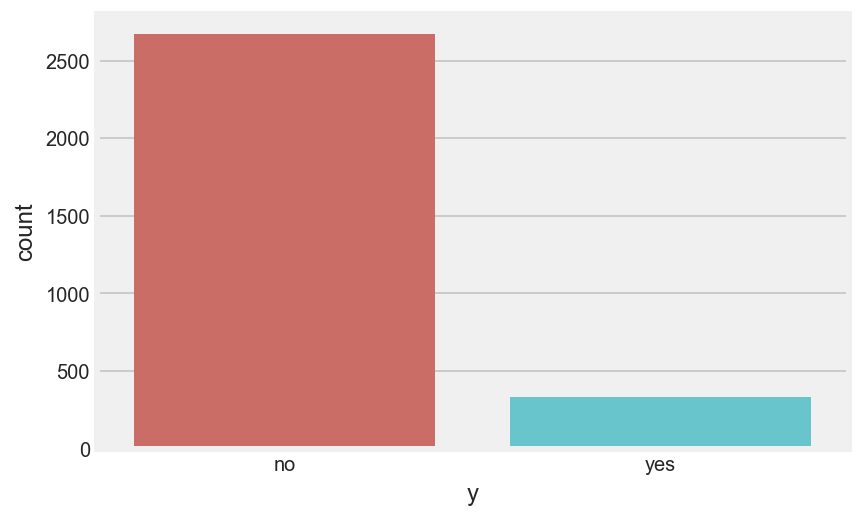

In [29]:
sns.countplot(x='y',data=data, palette='hls')
plt.show()

In [30]:
data.y=data.y.map(lambda x: 1 if x == 'yes' else 0)


# Check Collinearity

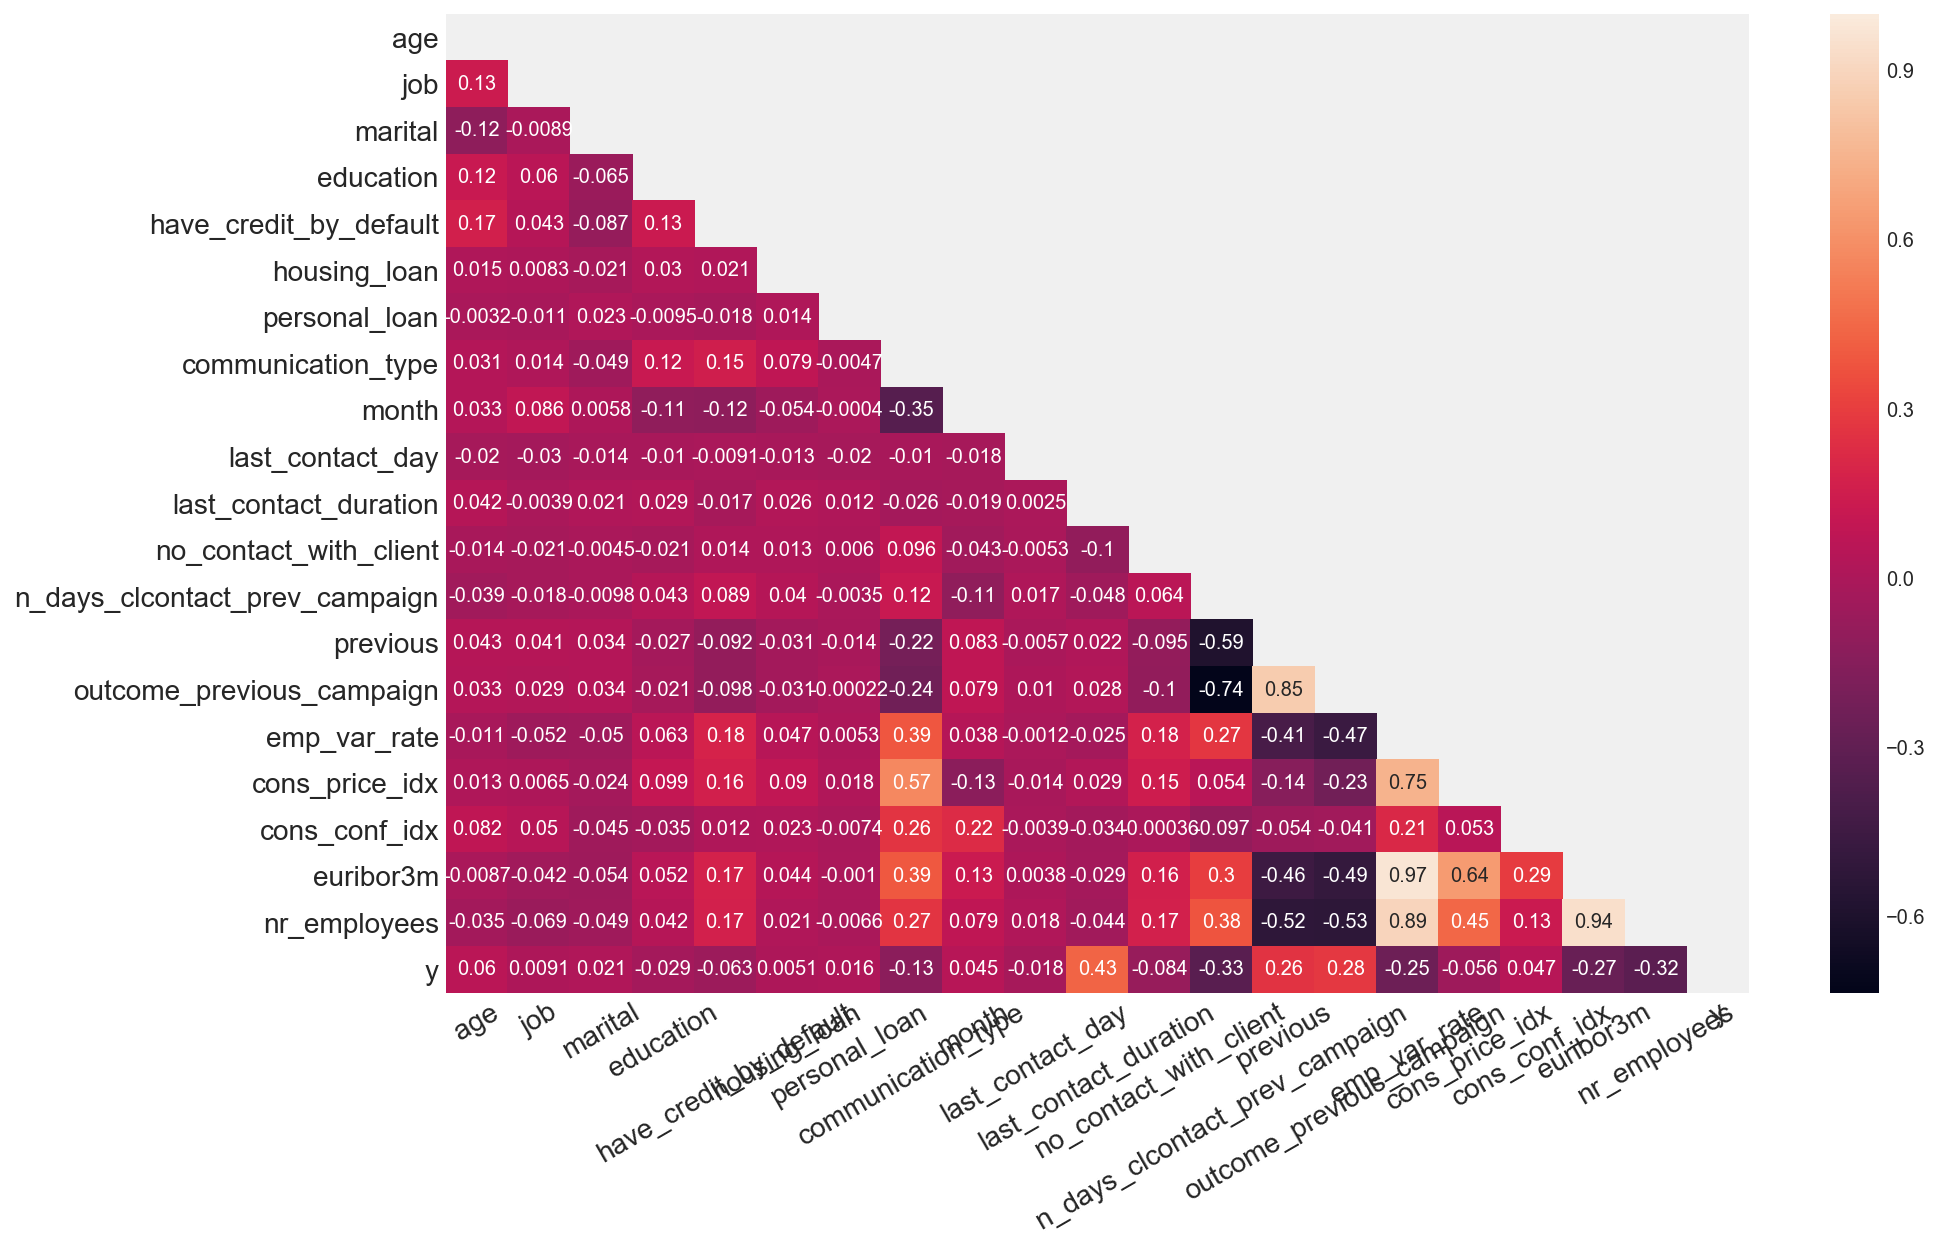

In [31]:
# i'll make a handy correlation matrix heatmap for my (reasonably) continuous measures:

def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(13,9))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=True)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()

#continuous = ['psoda','pfries','pentree','wagest','nmgrs','nregs','hrsopen','emp',
              #'density','crmrte','prpblck','prppov','prpncar','hseval','nstores',
              #'income']
#correlation_heat_map(food[continuous])
correlation_heat_map(data)

In [32]:
data.dtypes

age                                 int64
job                                 int64
marital                             int64
education                           int64
have_credit_by_default              int64
housing_loan                        int64
personal_loan                       int64
communication_type                  int64
month                               int64
last_contact_day                    int64
last_contact_duration               int64
no_contact_with_client              int64
n_days_clcontact_prev_campaign      int64
previous                            int64
outcome_previous_campaign           int64
emp_var_rate                      float64
cons_price_idx                    float64
cons_conf_idx                     float64
euribor3m                         float64
nr_employees                      float64
y                                   int64
dtype: object

In [33]:
data.isnull().sum()

age                               0
job                               0
marital                           0
education                         0
have_credit_by_default            0
housing_loan                      0
personal_loan                     0
communication_type                0
month                             0
last_contact_day                  0
last_contact_duration             0
no_contact_with_client            0
n_days_clcontact_prev_campaign    0
previous                          0
outcome_previous_campaign         0
emp_var_rate                      0
cons_price_idx                    0
cons_conf_idx                     0
euribor3m                         0
nr_employees                      0
y                                 0
dtype: int64

In [34]:
y = data.y.values
X = data.drop('y', axis=1)

In [35]:
from mlxtend.preprocessing import standardize
Xs=standardize(X)


In [36]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(Xs,15))
#CHECK THE SORTED CORRELATION

Top Absolute Correlations
emp_var_rate                    euribor3m                    0.969818
euribor3m                       nr_employees                 0.940440
emp_var_rate                    nr_employees                 0.892312
previous                        outcome_previous_campaign    0.852109
emp_var_rate                    cons_price_idx               0.746336
n_days_clcontact_prev_campaign  outcome_previous_campaign    0.735143
cons_price_idx                  euribor3m                    0.643663
n_days_clcontact_prev_campaign  previous                     0.591021
communication_type              cons_price_idx               0.566484
outcome_previous_campaign       nr_employees                 0.529039
previous                        nr_employees                 0.518301
outcome_previous_campaign       euribor3m                    0.493062
                                emp_var_rate                 0.466064
previous                        euribor3m                    0.4

# VIF

$$ V.I.F. = 1 / (1 - R^2). $$

The Variance Inflation Factor (VIF) is a measure of *colinearity among predictor variables* within a multiple regression. It is calculated by taking the the ratio of the variance of all .a given model's betas divide by the variane of a single beta if it were fit alone. Inspect the factors for each predictor variable, if the VIF is between *5-10*, multicolinearity is likely present and you should consider dropping the variable.

In [37]:
X1 = Xs._get_numeric_data() #drop non-numeric cols
X1.shape

(2999, 20)

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
vif["features"] = X1.columns
vif["features"] = X1.columns
vif.round(1)

,VIF Factor,features
0,1.1,age
1,1.0,job
2,1.0,marital
3,1.1,education
4,1.1,have_credit_by_default
5,1.0,housing_loan
6,1.0,personal_loan
7,2.7,communication_type
8,2.0,month
9,1.0,last_contact_day


In [39]:
col_del=['nr_employees','euribor3m']
X1.drop(columns=col_del,inplace=True)

In [40]:
vif2 = pd.DataFrame()
vif2["VIF Factor"] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
vif2["features"] = X1.columns
vif2["features"] = X1.columns
vif2.round(1)

,VIF Factor,features
0,1.1,age
1,1.0,job
2,1.0,marital
3,1.1,education
4,1.1,have_credit_by_default
5,1.0,housing_loan
6,1.0,personal_loan
7,2.1,communication_type
8,1.4,month
9,1.0,last_contact_day


In [41]:
print(get_top_abs_correlations(X1,15))

previous                        outcome_previous_campaign    0.852109
emp_var_rate                    cons_price_idx               0.746336
n_days_clcontact_prev_campaign  outcome_previous_campaign    0.735143
                                previous                     0.591021
communication_type              cons_price_idx               0.566484
outcome_previous_campaign       emp_var_rate                 0.466064
previous                        emp_var_rate                 0.409401
communication_type              emp_var_rate                 0.385667
                                month                        0.346923
n_days_clcontact_prev_campaign  emp_var_rate                 0.268007
communication_type              cons_conf_idx                0.262757
                                outcome_previous_campaign    0.236958
outcome_previous_campaign       cons_price_idx               0.229601
month                           cons_conf_idx                0.224391
communication_type  

In [42]:

col_del2=['outcome_previous_campaign']
X1.drop(columns=['outcome_previous_campaign'],inplace=True)

In [43]:
print(get_top_abs_correlations(X1,15))

emp_var_rate                    cons_price_idx            0.746336
n_days_clcontact_prev_campaign  previous                  0.591021
communication_type              cons_price_idx            0.566484
previous                        emp_var_rate              0.409401
communication_type              emp_var_rate              0.385667
                                month                     0.346923
n_days_clcontact_prev_campaign  emp_var_rate              0.268007
communication_type              cons_conf_idx             0.262757
month                           cons_conf_idx             0.224391
communication_type              previous                  0.216398
emp_var_rate                    cons_conf_idx             0.210984
have_credit_by_default          emp_var_rate              0.181479
no_contact_with_client          emp_var_rate              0.177880
age                             have_credit_by_default    0.166216
have_credit_by_default          cons_price_idx            0.16

In [44]:
vif3 = pd.DataFrame()
vif3["VIF Factor"] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
vif3["features"] = X1.columns
vif3["features"] = X1.columns
vif3.round(1)


,VIF Factor,features
0,1.1,age
1,1.0,job
2,1.0,marital
3,1.1,education
4,1.1,have_credit_by_default
5,1.0,housing_loan
6,1.0,personal_loan
7,2.1,communication_type
8,1.4,month
9,1.0,last_contact_day


In [45]:
col_del=['nr_employees','euribor3m','outcome_previous_campaign']#three variables will be deleted becasue of their high VIF

In [46]:
X.drop(columns=col_del,inplace=True)

In [47]:
data = data.drop(col_del, axis=1)

Imbalance is not defined formally but a ratio of 1 to 10 is usually imbalanced enough to benefit from using balancing technique.

In [48]:
data.to_csv("data_check_multi" , sep=',', encoding='utf-8')